In [ ]:
#hide
from utilities.ipynb_docgen import *
from nbdev import *

# Analyses

> Ongoing analyses


**`light_curves` library functions used here**
- `get_cells`
- `simulate_cells`
- `get_lightcurve`
- `get_bb_partition`
- `partition_cells`
- `fit_cells`
- `flux_plot`


## Introduction

This notebook does not produce a module to add to the library, it a place to run, and report on analyses using the library. It uses local code, shown below.

This is also an exploration of this style of presenting code, and data analysis based on it.

## Geminga analyses

Following Kerr's example, we use the source Geminga to verify that this analysis of data gives results consistent with its being constant. As you can see below, the BB analysis finds several breaks, which merit further checks. That is followed by a simulation using
Geminga's weight distribution and exposure. The run shown here finds one minor break, a change of 0.08%. 

**Local code**

In [ ]:
#collapse-hide
from light_curves.config import *
from light_curves.bayesian import *
from light_curves.simulation import *
from light_curves.lightcurve import *
from light_curves.cells import *

def bb_overplot(config, lc, bb_fit, ax=None,  **kwargs):
    fig, ax = plt.subplots(1,1, figsize=(12,4)) if not ax else (ax.figure, ax)
    flux_plot(config, lc, ax=ax, colors=(('lightblue', 'sandybrown', 'blue')),**kwargs)
    flux_plot(config, bb_fit, ax=ax, step=True, **kwargs)
    
def simulation(config, source, bb_key=None):
    """Create and analyze a a simulation for the source
    Returns the simulated, and fit light curves
    """

    lc = get_lightcurve(config, source)
    data_cells = get_cells(config, source)

    #  Get the rate from the data
    cq = data_cells.query('e>0.3')
    T, N = np.sum(cq.tw), np.sum(cq.n)
    sflux=lambda t: N/T

    # simulate, then fit cells to create a simulated light curve 
    sim_cells = simulate_cells(config, source, source_flux=sflux  )
    sim_lc  = fit_cells(config, sim_cells) 

    sim_edges = get_bb_partition(config, sim_lc,  key=bb_key) #'simulated_BB_partition_Geminga') 

    # partion, then fit the cells according to the edges
    sim_bb_cells = partition_cells(config, sim_cells, sim_edges);
    sim_bb_fit  = fit_cells(config, sim_bb_cells, )
    return sim_lc, sim_bb_fit

def analyze_data(config, source):
    """
    Analyze data from the source
    
    Returns, data a partitioned light curves
    """
    lc = get_lightcurve(config, source)
    cells = get_cells(config, source)
    edges = get_bb_partition(config, lc, LikelihoodFitness, key='bb-Geminga-test') 
    bb_cells = partition_cells(config, cells, edges);
    bb_lc  = fit_cells(config, bb_cells, )
    return lc, bb_lc

def fit_table(lc, expect=1.0):
    """Generate a summary table from a light curve"""
    fits = lc.fit
    flux = fits.apply(lambda f: f.flux)
    errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), round(f.errors[1]-f.flux ,3) ) )
    sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
    df = lc['t tw n'.split()].copy() # maybe fix warnings?
    df.loc[:,'flux'] = flux.values.round(4)
    df.loc[:, 'errors'] = errors.values
    df.loc[:, 'sigma_dev'] = sigma_dev.values
    return df

#### Current Cache contents

In [ ]:
config = Config()
print(config.cache)

Cache contents
 key                          size  time                 name, in folder /tmp/cache
  gti                      1018319  2020-12-27 07:24     cache_file_7190bdd9c0a092d.pkl
  photons_Geminga         22334705  2020-12-27 07:24     cache_file_14b520ba39961079.pkl
  weight_hist_Geminga          556  2020-12-27 07:25     cache_file_967f229ebf4ecb.pkl
  exposure_Geminga        86263776  2020-12-27 07:28     cache_file_28955455e5c2fbc.pkl
  binned_exposure_Geminga       64448  2020-12-27 07:28     cache_file_b02185c3dd43b6e.pkl



### Check fit to all simulated Geminga

Cell data for Geminga: Restoring from cache with key "cells_Geminga"
light_curves.loglike.LogLike:  time 56690.500, 1080435 weights, S 716237.6, B 364197.6 
Fit:  {'counts': 1080435, 'flux': 1.0, 'sig_flux': 0.0013}


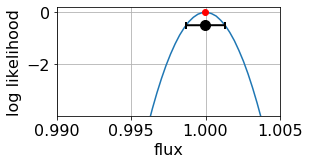

In [ ]:
from light_curves.loglike import *
if config.valid:
    source = PointSource('Geminga')
    cells = get_cells(config, source)
    cell = concatenate_cells(cells)

    ll = LogLike(cell); 
    print(ll,'\nFit: ', ll.fit_info())
    ll.plot(xlim =( 0.99, 1.005))

    cells.iloc[0]

In [ ]:
#collapse-hide
def analysis_plots(name, expect=0.9963, short=50, simname=''):
    """
    #### {sim} Geminga data
    
    {which_source} the daily binned data, or cells; then perform a Bayesian Blocks partition;
    finally make fits to the resulting blocks. <br>(Run at {date})
    
    {output}
    
    This shows the fits to all cells, with the BB fit overlays.
    {fig1}
    
    Since this is a constant source, there should be no breaks, that is, only one partition.
    Here is a table of the partition fits:
    
    {df_text}
    The last column represents the compatibility of the flux measurement for each partition
    with the expected value {expect} in equivalent sigma units.
    
    Expand the plot around short, < {short} day partitions.
    {short_check}
    
    {fig2}
    """
    source = PointSource(name)
    simulated = bool(simname)
    sim= 'Simulated' if simulated else ''
    which_source = 'Simulate a set of ' if simulated else 'Get'
    with capture_print('Analysis output' ) as output:
        if not simulated:
            lc, bb_lc = analyze_data(config, source)
        else: 
            lc, bb_lc = simulation(config, source, bb_key=simname) 

    pd.set_option('display.precision', 3)#, 'display.colheader_justify','left')
    
    df = fit_table(bb_lc, expect=expect)
    df_text = monospace(str(df), 'BB fit table', open=True)
        
    plt.rc('font', size=16)
    fig1, ax = plt.subplots(1,1, sharex=True, figsize=(10,4), num=1)
    bb_overplot(config, lc, bb_lc, ax = ax)
    ax.text(0.05, 0.85, name,  transform=ax.transAxes);
    fig1.width=600

    bb_short = bb_lc.query(f'tw<{short}'); ns =len(bb_short)
    if ns>0:
        short_check=f'There are {ns} such.'
        rows, cols = (ns+2)//3, 3
        fig2, axx = plt.subplots( rows,3,  figsize=(5*cols, 4*rows),
                                 sharey=True, sharex=True,
                     gridspec_kw=dict(top=0.85, left=0.08, bottom=0.15, hspace=0.2 ),num=2)
        if ns>1: fig2.width=600
        axf = axx.flatten()
        [ax.set_visible(False) for ax in axf[ns:]]
        for t, ax in zip(bb_short.t, axf):
            bb_overplot(config, lc, bb_lc, ax=ax, tzero=t, xlim=(-50, +50))
    else:
        fig2=''
        short_check = 'None found.'
    return locals()
if config.valid:
    nbdoc(analysis_plots, 'Geminga')

####  Geminga data

Get the daily binned data, or cells; then perform a Bayesian Blocks partition;
finally make fits to the resulting blocks. <br>(Run at 2020-12-27 07:34)

<details  class="nbdoc-description" >  <summary> Analysis output </summary>  <div style="margin-left: 5%"><pre>Light curve for Geminga: Saving to cache with key "lightfcurve_Geminga"<br>Cell data for Geminga: Restoring from cache with key "cells_Geminga"<br>Loaded 3873 / 4015 cells with exposure &gt; 0.3 for light curve analysis<br>first cell: t                                                    54683.5<br>tw                                                         1<br>e                                                    1.26456<br>n                                                        330<br>w          [0.95343286, 0.83939403, 0.68349504, 0.0219892...<br>S                                                    225.585<br>B                                                    114.707<br>loglike    light_curves.loglike.LogLike:  time 54683.500,...<br>Name: 0, dtype: object<br>Fitting likelihoods with poisson representation<br>Cell data for Geminga: Restoring from cache with key "cells_Geminga"<br>BB edges for...: Saving to cache with key "bb-Geminga-test"<br>Partitioned 3873 cells into 15 blocks, using LikelihoodFitness <br>Loaded 15 / 15 cells with exposure &gt; 0.3 for fitting<br></pre></div> </details>

This shows the fits to all cells, with the BB fit overlays.
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/analysis_plots_fig_01.png" title="images/analysis_plots_fig_01.png">    <img src="images/analysis_plots_fig_01.png" alt="Figure 1 at images/analysis_plots_fig_01.png" width=600>   </a> </figure>
</div>


Since this is a constant source, there should be no breaks, that is, only one partition.
Here is a table of the partition fits:

<details open class="nbdoc-description" >  <summary> BB fit table </summary>  <div style="margin-left: 5%"><pre>          t      tw       n   flux           errors  sigma_dev<br>0   55027.0   688.0  207832  1.002  (-0.003, 0.003)        1.9<br>1   55378.0    14.0    3797  1.126  (-0.024, 0.025)        5.4<br>2   55560.5   351.0   96416  0.988  (-0.004, 0.004)       -1.8<br>3   55748.0    24.0    6887  1.127  (-0.018, 0.018)        7.4<br>4   56114.0   708.0  191491  0.995  (-0.003, 0.003)       -0.5<br>5   56487.0    38.0   10741  1.082  (-0.014, 0.014)        6.2<br>6   56512.5    13.0    3402  0.905  (-0.021, 0.022)       -4.1<br>7   56673.5   309.0   84043  0.993  (-0.005, 0.005)       -0.8<br>8   56879.5   103.0   28168  1.030  (-0.008, 0.008)        4.1<br>9   56972.5    83.0   20961  0.969  (-0.009, 0.009)       -2.9<br>10  57017.5     7.0    2070  1.160  (-0.034, 0.034)        5.0<br>11  57109.0   176.0   45616  1.007  (-0.006, 0.006)        1.6<br>12  57197.5     1.0     149  0.538  (-0.067, 0.071)       -5.7<br>13  57917.5  1439.0  368600  0.998  (-0.002, 0.002)        0.7<br>14  58667.0    60.0   10261  1.082  (-0.015, 0.015)        6.0</pre></div> </details>
The last column represents the compatibility of the flux measurement for each partition
with the expected value 0.9963 in equivalent sigma units.

Expand the plot around short, < 50 day partitions.
There are 6 such.

<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/analysis_plots_fig_02.png" title="images/analysis_plots_fig_02.png">    <img src="images/analysis_plots_fig_02.png" alt="Figure 2 at images/analysis_plots_fig_02.png" width=600>   </a> </figure>
</div>



In [ ]:
#collapse-hide
if config.valid:

    nbdoc(analysis_plots, 'Geminga', name='analysis_sim',  simname='analysis_plot_sim', 
         expect=0.9915)

#### Simulated Geminga data

Simulate a set of  the daily binned data, or cells; then perform a Bayesian Blocks partition;
finally make fits to the resulting blocks. <br>(Run at 2020-12-27 07:38)

<details  class="nbdoc-description" >  <summary> Analysis output </summary>  <div style="margin-left: 5%"><pre>Light curve for Geminga: Restoring from cache with key "lightfcurve_Geminga"<br>Cell data for Geminga: Restoring from cache with key "cells_Geminga"<br>binned exposure for source Geminga: Restoring from cache with key "binexp_Geminga"<br>Weight histogram for Geminga: Restoring from cache with key "weight_hist_Geminga"<br>Loaded 3873 / 4015 cells with exposure &gt; 0.3 for fitting<br>BB edges for...: Saving to cache with key "analysis_plot_sim"<br>Partitioned 3873 cells into 1 blocks, using LikelihoodFitness <br>Loaded 1 / 1 cells with exposure &gt; 0.3 for fitting<br></pre></div> </details>

This shows the fits to all cells, with the BB fit overlays.
<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/analysis_sim_fig_01.png" title="images/analysis_sim_fig_01.png">    <img src="images/analysis_sim_fig_01.png" alt="Figure 1 at images/analysis_sim_fig_01.png" width=600>   </a> </figure>
</div>


Since this is a constant source, there should be no breaks, that is, only one partition.
Here is a table of the partition fits:

<details open class="nbdoc-description" >  <summary> BB fit table </summary>  <div style="margin-left: 5%"><pre>         t      tw        n   flux           errors  sigma_dev<br>0  56690.0  4014.0  1116345  0.989  (-0.001, 0.001)       -2.1</pre></div> </details>
The last column represents the compatibility of the flux measurement for each partition
with the expected value 0.9915 in equivalent sigma units.

Expand the plot around short, < 50 day partitions.
None found.




## TO DO
- Fix a 0.4% bias from the cell fit when applied to high-statisics data.

- Look at the 6 intervals detected for the data, of which 5 have measured flux increases around 10%,  more than 4$\sigma$. Possibilities are a problem with the exposure, and a change in the background. The latter can be examined by a 2-D fit with $\beta$ free. Another possibility, fixing $\alpha=0$ and fitting $\beta$ is not (yet) supported.


In [ ]:
!date

Sun Dec 27 07:43:36 PST 2020
